## NYC Neighborhood Commute Time: 

# Buying a Home in NYC: What Neighborhoods are the Best Value?
### Applying Data Science Tools to Understand NYC's Residential Real Estate Fundamentals

    Josh Grasso | joshgrasso@gmail.com
This project seeks to understand the fundamental factors that explain differences in residential real estate prices across NYC. 

### Neighborhood Commute Time: via Public Transit to Midtown Manhattan using Google Maps Directions API
Manhattan is the obvious cultural and commercial epicenter of all of New York City, and the region. And a neighborhoods proximity to the epicenter is a key feature in understanding its own real estate development, the mix of professionals and the income of its residents. When choosing between neighborhoods within Manhattan, commute time to work is an important consideration – working on the West-side and living on the East-side is an inconvenience.  And when choosing between one neighborhood in an outer borough, or another, a very important consideration is how long does it take to get to Manhattan – for work, for restaurants, for museums and theater. The analogy holds even traveling out to nearby states - in Connecticut, Greenwich has a premium to Stamford, which has a premium to Norwalk and Fairfield. 

To capture this information across neighborhoods, I chose to focus on commuting to work, where midtown is the commercial epicenter of Manhattan, and pretty close to the geographic center as well. Grand Central is an obvious destination, and a comparable destination with which to compare commute times for outer suburbs as well – for a future iteration of the analysis. To remove any bias to the East-side, and neighborhoods along the green subway line, I also include the commute time to Times Square-42nd Street – which adds the red and yellow subway lines, and is even connected to Grand Central by shuttle. 

Thus, I asked the Google Maps Directions API for all the routes, via public transportation, from the center of each neighborhood to both Grand Central and Times Square subway stations. Public transit includes the ferry – for Staten Island – and bus routes – Oakland Gardens, Queen is a great example. I then selected the route(s) to either station with the fewest amount of transfers, and among those chose the fastest-route as the final commute time for the neighborhood. 


The end result is that single-family home prices in NYC, as measured in the Zillow dataset, were -50% correlated to the commute time to Midtown Manhattan, overall a strong result. This was the strongest correlation among the commute metrics I extracted from Google Maps Directions – as intended. The correlation falls to 28% between prices to the number of commute transfers, and falls to 17% between prices and the amount of walking that is included in the commute route. Neighborhoods further from a subway station will have more walking time/distance included in the fastest route. For simplicity, I only included the travel time (minutes) in the regression analysis. However, I think there is additional information in the other variables as well: how many transfers the commute requires, if the commute requires taking the ferry or a bus, and how far away the nearest subway station is located.  


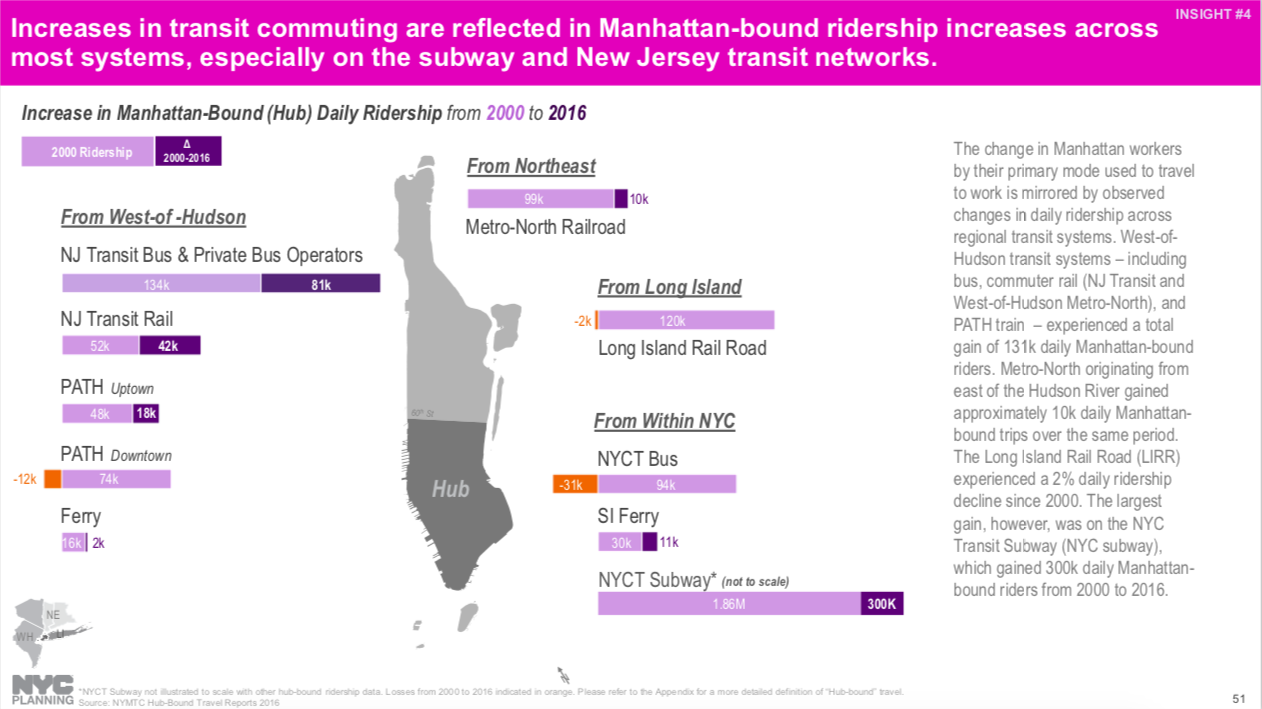

In [28]:
from IPython.display import Image
from pathlib import Path
home_path = Path.home() / 'Jupyter' / 'Real_Estate'
Image(filename= home_path / 'Manhattan_Workers_Transit_Mode2.png')
# NYC Department of Planning, The Ins and Outs of NYC Commuting, September 2019
# Source: https://www1.nyc.gov/assets/planning/download/pdf/planning-level/housing-economy/nyc-ins-and-out-of-commuting.pdf

The NYC Department of Planning has a great presentation detailing all as aspects of NYC commuting patterns. The data says that of the 2.6 mm individuals who work in Manhattan for the year 2017, 30% or 750k actually live in Manhattan, followed by 468k or 18% that live in Brooklyn, 396k or 15% live in Queens, 338k or 13% live in Northern New Jersey (think Hoboken, Jersey City, and suburbs), 216k or 8% live in the Bronx, and 50k, or 2% live in Staten Island. Manhattan is the only borough or surrounding region with a higher worker-to-resident ratio at 2.9x – all other regions have more residents than workers/local jobs. As a percentage of residents, 39% of Brooklyn residents commute to Manhattan for work, similar to 38% of Bronx residents, followed by 36% of Queens’ residents, and 24% of Staten Island residents. 

Further, the slide below details how the individuals working in the “hub” region of Manhattan – Midtown, south through the Financial District – get to work. The subway is the clear leader at 2.1 mm workers, followed by the 222k who take NJ Transit or Path trains, 215k take the bus from NJ, 118k take the Long Island Rail-Road, 109k take the Metro-North railroad, 63k take the local MTA bus, and 41k take the Staten Island ferry. 

In [ ]:
# Commute Times
# https://www.nytimes.com/interactive/2019/07/08/upshot/nyc-subway-variability-calculator.html
# https://streeteasy.com/blog/nyc-subway-neighborhoods-best-worst-access/


In [7]:
import numpy as np
import pandas as pd
import requests

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn')  
sns.set()

from datetime import datetime
today = datetime.now()
month,day,year = today.month,today.day,today.year

In [8]:
# from pathlib import Path
# home_path = Path.home() / 'Jupyter' / 'Real_Estate'

In [9]:
# Neighborhood Coordinates: 
# Neighborhoods Names
# https://www1.nyc.gov/site/planning/data-maps/open-data.page

neighborhood_url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/Neighborhood_Names/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
resp = requests.get(neighborhood_url)
neighborhood_json = resp.json()

neighborhood_ids_list = []
neighborhood_details_list = []

for neighborhood_dict in neighborhood_json['features']:
    neighborhood_ids_list.append(neighborhood_dict['id']) 
    
    d = {}
    d['ID'] = neighborhood_dict['id']
    d['Name'] = neighborhood_dict['properties']['Name']
    d['Borough'] = neighborhood_dict['properties']['Borough']
    d['Lat'] = neighborhood_dict['geometry']['coordinates'][1]
    d['Long'] = neighborhood_dict['geometry']['coordinates'][0]
    
    neighborhood_details_list.append(d)

neighborhood_df = pd.DataFrame.from_dict(neighborhood_details_list)
neighborhood_df['Borough'] = neighborhood_df['Borough'].replace({'Staten Island': 'Staten_Island'})
neighborhood_df = neighborhood_df.set_index(['Name','Borough'])


In [10]:
neighborhood_df  # .set_index(['Name','Borough'])

,,ID,Lat,Long
Name,Borough,,,
Wakefield,Bronx,1,40.894713,-73.847202
Co-op City,Bronx,2,40.874302,-73.829941
Eastchester,Bronx,3,40.887564,-73.827808
Fieldston,Bronx,4,40.895446,-73.905644
Riverdale,Bronx,5,40.890843,-73.912587
...,...,...,...,...
Stapleton,Staten_Island,302,40.626936,-74.077903
Rosebank,Staten_Island,303,40.615313,-74.069807
West Brighton,Staten_Island,304,40.631887,-74.107183


In [11]:
# Google Maps:
# Call My Google API Key:  Next-step: Write and save into a .py file and call the file
MyGoogleAPIKey_path = Path.home() / 'Jupyter' / Path('My_Google_API_Key.txt')
if MyGoogleAPIKey_path.is_file():
    MyGoogleAPIKey_file = open(MyGoogleAPIKey_path, 'rt')
    my_gmaps_key = MyGoogleAPIKey_file.read()
    MyGoogleAPIKey_file.close()
else:
    print('Error: File not found')

In [12]:
from pandas.tseries.offsets import BDay

def gmaps_directions(my_gmaps_key, start_lat, start_long, destination_id='ChIJhRwB-yFawokRi0AhGH87UTc'):
    # 'https://maps.googleapis.com/maps/api/directions/json?parameters'
    
    # Build URL:
    gmaps_url = 'https://maps.googleapis.com/maps/api/directions/json?'
    
    gmaps_url += "&origin={},{}".format(str(start_lat), str(start_long))
    gmaps_url += "&destination=place_id:{}".format(destination_id)
    gmaps_url += "&mode=transit"
    gmaps_url += "&transit_mode=subway"
    gmaps_url += "&transit_routing_preference=fewer_transfers"
    
    # You can specify the time as an integer in seconds since midnight, January 1, 1970 UTC
    today = datetime.now()
    search_time = (pd.Timestamp('{}-{}-{} 8:30'.format(today.year, today.month, (today + BDay(1)).day), 
                                tz='America/New_York'))  
    departure_time = str(search_time.value)[:-9]
    gmaps_url += "&departure_time={}".format(departure_time)
    
    gmaps_url += "&alternatives=true"
    gmaps_url += "&key={}".format(my_gmaps_key)
    
    return requests.get(gmaps_url).json()


In [25]:
#i=0
#j=1
#_directions_json['routes'][i]['legs'][0]['steps'][j]['transit_details'] #['line']['short_name']

In [13]:
def parse_directions(gmaps_directions_json):
    master_list = []
    # Loop through each Alternative Route:
    for route in gmaps_directions_json['routes']:
        columns_list = ['Entry_station', 'Station_Lat', 'Station_Long',
                        'Travel_time', 'Transit_transfers',  # 'Duration_txt', 
                        'Walking_time', 'Walking_distance', 'Subway_lines'] # 'Neighborhood', 
        route_dict = dict.fromkeys(columns_list)
        
        # For routes that contain no waypoints, the route will consist of a single "leg,"
        #route_dict['Duration_txt'] =  route['legs'][0]['duration']['text']
        route_dict['Travel_time'] = route['legs'][0]['duration']['value'] / 60  # seconds to minutes
        
        # Loop through each Step:
        walking_time = 0
        walking_distance = 0
        subway_string = ''
        transit_transfers = 0
        for step in route['legs'][0]['steps']:
            if step['travel_mode'] == 'WALKING':
                walking_time += step['duration']['value'] / 60  # seconds to minutes
                walking_distance += step['distance']['value'] / 1610  # meters to miles
            elif step['travel_mode'] == 'TRANSIT':
                transit_transfers += 1
                if transit_transfers == 1:
                    route_dict['Entry_station'] = step['transit_details']['departure_stop']['name']
                    route_dict['Station_Lat'] = step['transit_details']['departure_stop']['location']['lat']
                    route_dict['Station_Long'] = step['transit_details']['departure_stop']['location']['lng']
                subway_string += step['transit_details']['line']['name'] + ';'  # short_name
            else:
                pass
            route_dict['Walking_time'] = walking_time
            route_dict['Walking_distance'] = walking_distance
            route_dict['Transit_transfers'] = transit_transfers
            route_dict['Subway_lines'] = subway_string
        master_list.append(route_dict)
    return pd.DataFrame(master_list)


In [14]:
# Destinations: 
destination_id_dict = {'Grand Central Terminal': 'ChIJhRwB-yFawokRi0AhGH87UTc',
                      'Times Sq - 42 St': 'ChIJ10bnS6tZwokROfmCPOetmk0'}
# - or - Penn Station? 
# Penn Station Place ID: ChIJI2HvCK5ZwokRDzoIZCfLoPc  
# New York Penn Station Place ID: ChIJZ278179ZwokRi6_g2g7zoG0
# Penn Station LIRR Place ID: ChIJ30bGgq5ZwokR4NkG2EK7qN8

# Source: https://developers.google.com/maps/documentation/javascript/examples/places-placeid-finder

In [28]:
# Main Loop: 
# Build df with all routes for all neighborhoods
#i = 0
all_routes_df = pd.DataFrame()
for x, y in zip(neighborhood_df.reset_index(drop=False)['Name'], 
                neighborhood_df.reset_index(drop=False)['Borough']):
    #print(neighborhood_df['Lat'].loc[x, y])
    #print(neighborhood_df['Long'].loc[x, y])
    for destination in destination_id_dict.keys():    
        _directions_json = gmaps_directions(my_gmaps_key,
                                            neighborhood_df['Lat'].loc[x, y], neighborhood_df['Long'].loc[x, y],
                                            destination_id=destination_id_dict[destination])
        _directions_df = parse_directions(_directions_json)
        _directions_df['Destination_station'] = destination
        _directions_df['Neighborhood'] = x
        _directions_df['Borough'] = y
        all_routes_df = all_routes_df.append(_directions_df)
        
    #i += 1
    #if i == 5:
        #break
all_routes_df = all_routes_df.reset_index(drop=True)

In [29]:
all_routes_df

,Entry_station,Station_Lat,Station_Long,Travel_time,Transit_transfers,Walking_time,Walking_distance,Subway_lines,Destination_station,Neighborhood,Borough
0,233 St,40.8932,-73.8575,68.300000,2.0,15.283333,0.664596,2 Line;4 Line;,Grand Central Terminal,Wakefield,Bronx
1,233 St,40.8932,-73.8575,76.300000,2.0,15.283333,0.664596,2 Line;5 Line;,Grand Central Terminal,Wakefield,Bronx
2,233 St,40.8932,-73.8575,68.300000,2.0,15.283333,0.664596,2 Line;4 Line;,Grand Central Terminal,Wakefield,Bronx
3,Nereid Av,40.8984,-73.8544,80.800000,2.0,17.483333,0.796894,2 Line;42 Street Shuttle;,Grand Central Terminal,Wakefield,Bronx
4,Nereid Av,40.8984,-73.8544,72.616667,1.0,13.616667,0.676398,2 Line;,Times Sq - 42 St,Wakefield,Bronx
...,...,...,...,...,...,...,...,...,...,...,...
2387,Richmond Rd/Seaview Av,40.5913,-74.1009,107.933333,4.0,29.483333,1.503106,St. George - Bricktown Mall;College of Staten ...,Grand Central Terminal,Todt Hill,Staten_Island
2388,Richmond Rd/Seaview Av,40.5913,-74.1009,103.316667,3.0,25.683333,1.410559,St. George - Oakwood;Staten Island Ferry;1 Line;,Times Sq - 42 St,Todt Hill,Staten_Island
2389,Richmond Rd/Seaview Av,40.5913,-74.1009,104.366667,4.0,21.416667,1.186335,St. George - Bricktown Mall;College of Staten ...,Times Sq - 42 St,Todt Hill,Staten_Island
2390,Richmond Rd/Seaview Av,40.5913,-74.1009,112.866667,3.0,21.416667,1.186335,St. George - Bricktown Mall;College of Staten ...,Times Sq - 42 St,Todt Hill,Staten_Island


In [30]:
#all_routes_df = all_routes_df.set_index(['Neighborhood','Borough'])

In [35]:
neighborhood_df.reset_index()[neighborhood_df.reset_index()['Name'] == 'Howland Hook']

,Name,Borough,ID,Lat,Long
145,Howland Hook,Staten_Island,146,40.638441,-74.186225


In [33]:
all_routes_df[all_routes_df['Neighborhood'] == 'Howland Hook']

,Entry_station,Station_Lat,Station_Long,Travel_time,Transit_transfers,Walking_time,Walking_distance,Subway_lines,Destination_station,Neighborhood,Borough


In [39]:
# Find Single Best Route
# Fastest route, with fewest transfers, for each neighborhood
#single_route_df = pd.DataFrame(index=neighborhood_df.index, columns=all_routes_df.columns)
single_route_df = pd.DataFrame()
missing_route_list = []
#i = 0
for x, y in zip(neighborhood_df.reset_index(drop=False)['Name'], 
                neighborhood_df.reset_index(drop=False)['Borough']):
    #print(neighborhood_df['Lat'].loc[x, y])
    #print(neighborhood_df['Long'].loc[x, y])
    try:
        _neighborhood_directions_df = all_routes_df.set_index(['Neighborhood','Borough']).loc[x, y]
    except:
        missing_route_list.append((x, y))
        continue
    
    _min_transfers_df = (_neighborhood_directions_df[_neighborhood_directions_df['Transit_transfers'] == 
                                                     _neighborhood_directions_df['Transit_transfers'].min()])
    
    if isinstance(_min_transfers_df, pd.Series):
        single_route_df = single_route_df.append(_min_transfers_df)
    if isinstance(_min_transfers_df, pd.DataFrame):
        #single_route_df.append(all_routes_df.iloc[_min_transfers_df['Travel_time'].idxmin()])
        _min_transfers_df = _min_transfers_df.reset_index(drop=False)
        single_route_df = single_route_df.append(_min_transfers_df
                                                 .iloc[_min_transfers_df['Travel_time'].idxmin()])
    #i += 1
    #if i == 5:
        #break

<ipython-input-39-313443ce9c48>:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  _neighborhood_directions_df = all_routes_df.set_index(['Neighborhood','Borough']).loc[x, y]


In [40]:
single_route_df

,Borough,Destination_station,Entry_station,Neighborhood,Station_Lat,Station_Long,Subway_lines,Transit_transfers,Travel_time,Walking_distance,Walking_time
2,Bronx,Times Sq - 42 St,Nereid Av,Wakefield,40.898380,-73.854378,2 Line;,1.0,67.116667,0.676398,13.616667
1,Bronx,Grand Central Terminal,Baychester Avenue Station,Co-op City,40.878662,-73.838593,5 Line;,1.0,67.683333,0.859006,19.166667
0,Bronx,Grand Central Terminal,Eastchester - Dyre Av,Eastchester,40.888302,-73.830833,5 Line;,1.0,57.983333,0.362112,7.966667
1,Bronx,Times Sq - 42 St,242 Street Station,Fieldston,40.889248,-73.898582,1 Line;,1.0,57.916667,1.118634,19.383333
1,Bronx,Times Sq - 42 St,238th Street Station,Riverdale,40.884666,-73.900871,1 Line;,1.0,55.350000,0.934783,18.350000
...,...,...,...,...,...,...,...,...,...,...,...
3,Staten_Island,Times Sq - 42 St,Bay St/Water St,Stapleton,40.627083,-74.075821,St. George - West Shore Plaza;Staten Island Fe...,3.0,68.350000,0.550311,10.033333
1,Staten_Island,Grand Central Terminal,Tompkins Ave/St Mary's Av,Rosebank,40.613789,-74.072304,St. George - Staten Island Univ. Hospital;Stat...,3.0,65.650000,0.300621,7.033333
2,Staten_Island,Times Sq - 42 St,Castleton Ave/Bard Av,West Brighton,40.634644,-74.106163,St. George - West Shore Plaza LTD;Staten Islan...,3.0,77.483333,0.696894,12.583333
2,Staten_Island,Times Sq - 42 St,Broad St/Gordon St,Grymes Hill,40.623623,-74.082390,St. George - Bricktown Mall;Staten Island Ferr...,3.0,78.483333,0.851553,15.900000


In [41]:
missing_route_list

[('Howland Hook', 'Staten_Island'), ('Breezy Point', 'Queens')]

In [42]:
# Save to CSV:
all_routes_df.to_csv(path_or_buf= home_path / 'Google_Maps_All_Routes.csv')
single_route_df.to_csv(path_or_buf= home_path / 'Google_Maps_Single_Route.csv')

In [17]:
# Compare Commute Features to Prices: 
growth_zillow_2005_2019_df = pd.read_csv(home_path / 'Zillow' / 'Zillow_NYC_SFR_2005_2019.csv',
                                         index_col=[0,1])
growth_zillow_2005_2019_df.head(2)

,,Avg_Price_2005_2019,Annual_Growth_2005_2019,Growth_%_2005_2019
Borough,Neighborhood,,,
Queens,Hunters Point,333275.455556,29088.598191,0.087281
Manhattan,Manhattanville,503046.054264,42159.332200,0.083808


In [21]:
transit_anlysis = (growth_zillow_2005_2019_df.join(
    single_route_df[['Borough', 'Neighborhood', 'Transit_transfers', 'Travel_time', 
                     'Walking_distance', 'Walking_time']].set_index(['Borough','Neighborhood'])))
# transit_anlysis[transit_anlysis.isnull().any(axis=1)]
transit_anlysis = transit_anlysis.drop(index=transit_anlysis[transit_anlysis.isnull().any(axis=1)].index)
transit_anlysis = transit_anlysis.sort_values(by='Avg_Price_2005_2019', ascending=False)
transit_anlysis['Avg_Price'] = transit_anlysis['Avg_Price_2005_2019'] /1000 # .apply(lambda x: x/1000/1000)


In [26]:
transit_anlysis[['Transit_transfers', 'Travel_time', 'Walking_distance', 'Walking_time', 'Avg_Price']].round(1)

Transit_transfers  Travel_time  \
Borough       Neighborhood                                         
Manhattan     Carnegie Hill                     1.0         17.2   
              Upper East Side                   1.0         14.3   
              Little Italy                      1.0         16.7   
              Greenwich Village                 1.0         15.5   
              West Village                      1.0         13.0   
...                                             ...          ...   
Queens        Rochdale                          2.0         53.9   
Bronx         Parkchester                       1.0         46.7   
Staten_Island Port Ivory                        3.0         95.3   
Bronx         Westchester Square                1.0         44.2   
              Unionport                         1.0         45.0   

                                  Walking_distance  Walking_time  Avg_Price  
Borough       Neighborhood                                                   
Manhattan     Carnegie Hill                    0.3           6.7     8044.2  
              Upper East Side                  0.3           5.8     6311.3  
              Little Italy                     0.4           7.2     5957.6  
              Greenwich Village                0.4           8.5     4930.8  
              West Village                     0.3           6.0     4922.5  
...                                            ...           ...        ...  
Queens        Rochdale                         0.7          14.6      311.3  
Bronx         Parkchester                      0.5          10.2      300.4  
Staten_Island Port Ivory                       0.9          17.3      296.2  
Bronx         Westchester Square               0.1           3.2      266.6  
              Unionport                        0.4           8.5      156.3  

[234 rows x 5 columns]

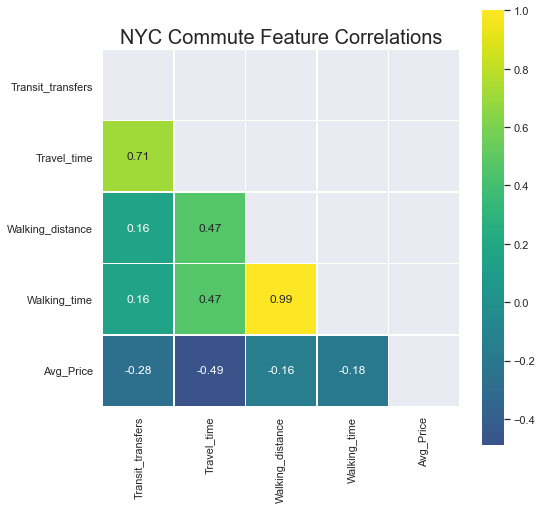

In [24]:
# Feature Correlation:
corr = (transit_anlysis[['Transit_transfers', 'Travel_time', 'Walking_distance', 'Walking_time', 'Avg_Price']]
        .corr().round(2))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap=sns.color_palette("viridis", as_cmap=True) # 'PuOr' 'viridis'

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, center=0, vmax=1, annot=True, ax=ax);
plt.title("NYC Commute Feature Correlations", fontsize=20);

In [ ]:
# Map: Walking Distance to Nearest Subway 

# http://faculty.baruch.cuny.edu/geoportal/data/nyc_gdb/sample_maps/subway_ac.pdf


In [ ]:
# Map MTA Turnstile Data

"""
subway_stations_url = 'http://web.mta.info/developers/data/nyct/subway/Stations.csv'
# Resource: 'https://qri.cloud/nyc-transit-data/stationscsv'

resp = requests.get(subway_stations_url)
local_path = home_path / 'MTA_Subway_Stations.csv'
with open(local_path, 'wb') as output:
    output.write(resp.content)

subway_stations_df = pd.read_csv(local_path)
"""